# Setup

In [1]:
# Step 1: Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Load the datasets
policy_df = pd.read_csv('csv/all_data_en.csv')
region = pd.read_csv('csv/region.csv')

# Step 3: Merge the region information with policy data
region = region[['alpha-3', 'region', 'sub-region', 'intermediate-region']]
policy_df = policy_df.merge(region, left_on='Geography ISO', right_on='alpha-3', how='left')

# Step 4: Show the first few rows to verify the data merge
policy_df.head()

,index,Document ID,Document Title,Family ID,Family Title,Family Summary,Collection Title(s),Collection Description(s),Document Role,Document Variant,...,Internal Collection ID(s),have_support_doc?,raw_doc_path,doc_id,text_file_path,lang,alpha-3,region,sub-region,intermediate-region
0,0,act-on-the-promotion-of-the-development-use-an...,"Act on the Promotion of the Development, Use a...",act-on-the-promotion-of-the-development-use-an...,"Act on the Promotion of the Development, Use a...",The revised Act on the Promotion of the Develo...,NaN,NaN,Main,Original Language,...,NaN,True,climate_laws/1_pdfs/document_0.pdf,document_0,../climate_laws\en_cleaned_text_1\document_0.txt,en,KOR,Asia,Eastern Asia,NaN
1,4728,national-redd-strategy-2017-2027-nec-decision-...,National REDD+ Strategy 2017-2027 (NEC decisio...,national-redd-strategy-2017-2027-nec-decision-...,National REDD+ Strategy 2017-2027 (NEC decisio...,The strategy is a key part of the country's re...,NaN,NaN,Main,NaN,...,NaN,True,climate_laws/1_pdfs/document_4628.pdf,document_4628,../climate_laws\en_cleaned_text_2\document_462...,en,PNG,Oceania,Melanesia,NaN
2,4740,act-on-the-improvement-of-energy-consumption-p...,Act on the Improvement of Energy Consumption P...,act-on-the-improvement-of-energy-consumption-p...,Act on the Improvement of Energy Consumption P...,This Act provides for 1) regulatory measures f...,NaN,NaN,Main,NaN,...,NaN,True,climate_laws/1_pdfs/document_4640.pdf,document_4640,../climate_laws\en_cleaned_text_1\document_464...,en,JPN,Asia,Eastern Asia,NaN
3,4739,climate-protection-policy-executive-summary_4e45,Climate Protection Policy: Executive Summary,climate-protection-policy-government-resolutio...,"Climate Protection Policy, Government Resoluti...",The Climate Protection Policy (CPP) of 2017 is...,NaN,NaN,Summary,NaN,...,NaN,True,climate_laws/1_pdfs/document_4639.pdf,document_4639,../climate_laws\en_cleaned_text_1\document_463...,en,CZE,Europe,Eastern Europe,NaN
4,4736,forest-law-of-the-people-s-republic-of-china_7bd3,Forest Law of the People's Republic of China,forest-law-of-the-people-s-republic-of-china_15c2,Forest Law of the People's Republic of China,"This law aims at protecting, cultivating and r...",NaN,NaN,Main,NaN,...,NaN,True,climate_laws/7_pdfs/document_4636.pdf,document_4636,../climate_laws\en_cleaned_text_1\document_463...,en,CHN,Asia,Eastern Asia,NaN


# Visualizing the distribution before splitting:

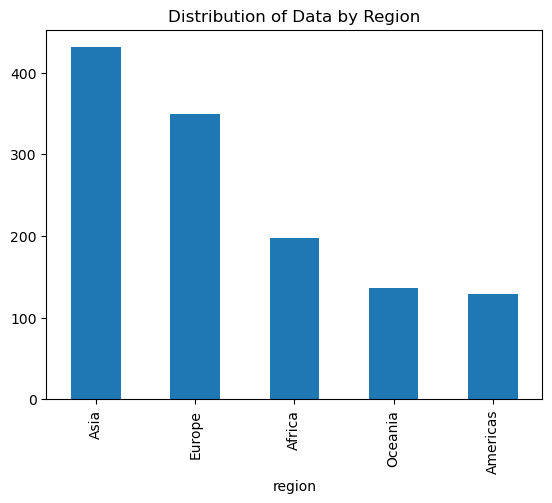

In [2]:
# Step 5: Visualize the distribution by 'region'
region_distribution = policy_df['region'].value_counts()
region_distribution.plot(kind='bar', title='Distribution of Data by Region')
plt.show()

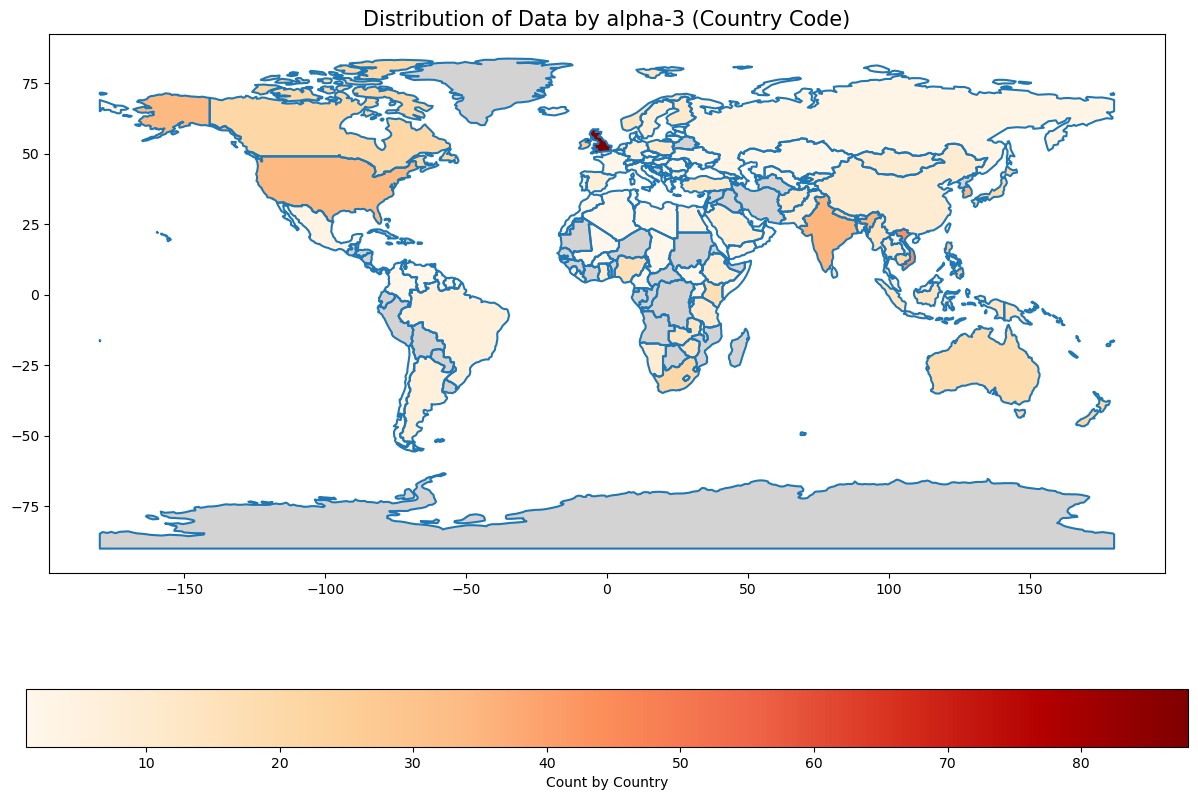

In [3]:
# Step 6: Visualize the distribution by 'alpha-3' on a world map
import geopandas as gpd
import matplotlib.pyplot as plt

# Get the world map shape file from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Prepare the 'alpha-3' distribution from the policy_df
alpha_distribution = policy_df['alpha-3'].value_counts().reset_index()
alpha_distribution.columns = ['alpha-3', 'count']

# Merge the world map with the alpha-3 distribution data
# Note: The 'iso_a3' column in the world dataset contains the ISO 3-letter country codes
world = world.merge(alpha_distribution, left_on='iso_a3', right_on='alpha-3', how='left')

# Plot the world map with the distribution data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)  # Plot boundaries of the countries
world.plot(column='count', ax=ax, legend=True, 
           legend_kwds={'label': "Count by Country", 'orientation': "horizontal"},
           cmap='OrRd', missing_kwds={"color": "lightgrey"})  # Use a color map

# Add title and show the plot
plt.title('Distribution of Data by alpha-3 (Country Code)', fontsize=15)
plt.show()

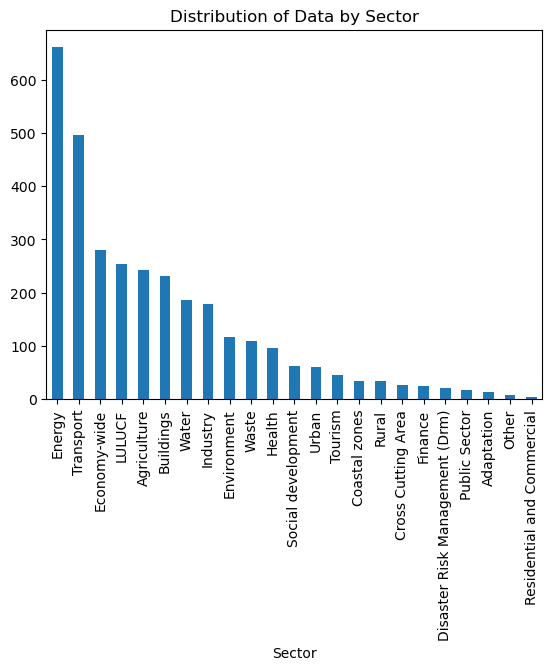

In [4]:
# Step 7: Visualize the distribution by 'Sector' (handling multiple sectors)
# Split the 'Sector' column by ';' and explode the rows so that each sector is treated separately
policy_df_temp = policy_df.copy()
policy_df_temp['Sector'] = policy_df_temp['Sector'].str.split(';')
exploded_df = policy_df_temp.explode('Sector')  # This will create a new row for each sector

# Visualize the distribution of Sectors
sector_distribution = exploded_df['Sector'].value_counts()
sector_distribution.plot(kind='bar', title='Distribution of Data by Sector')
plt.show()

# Splitting the data:

In [5]:
import numpy as np
import pandas as pd

# Step 7: Ensure the 'Sector' column is treated properly by splitting and rejoining later
policy_df['Sector'] = policy_df['Sector'].str.split(';')

# Step 8: Create an empty test set dataframe
test_set = pd.DataFrame()

# Step 9: Ensure test set has all regions (at least one policy from each region)
regions_needed = policy_df['region'].unique()
np.random.seed(42)  # For reproducibility

# Step 10: Loop through each region and select at least one random policy from each region to satisfy the conditions
for region in regions_needed:
    region_data = policy_df[policy_df['region'] == region]
    
    # Drop duplicates based on 'alpha-3' (ensuring no duplicate policies per country)
    region_data = region_data.drop_duplicates(subset=['alpha-3'])

    # Randomly select one row from each region to ensure representation in the test set
    if not region_data.empty:
        sampled_data = region_data.sample(1, random_state=42)  # Select one random policy
        test_set = pd.concat([test_set, sampled_data])

# Step 11: Randomly sample additional rows to reach 100 policies, while satisfying the conditions
while len(test_set) < 100:
    remaining_data = policy_df.drop(test_set.index)  # Exclude already selected policies
    remaining_data = remaining_data.drop_duplicates(subset=['alpha-3'])  # Ensure no duplicate alpha-3
    
    # Sample additional rows until we reach 100
    num_to_sample = min(100 - len(test_set), len(remaining_data))
    sampled_data = remaining_data.sample(num_to_sample, random_state=42)
    test_set = pd.concat([test_set, sampled_data])

# Step 12: Finalize the test set size (100 unique policies)
test_set = test_set.drop_duplicates(subset=['alpha-3']).sample(100, random_state=42)

# Step 13: Create the train set by excluding the test set
train_set = policy_df.drop(test_set.index)

# Step 14: Rejoin the 'Sector' information back by combining multiple sectors into a single row using ';'
# For both test and train sets
test_set['Sector'] = test_set['Sector'].apply(lambda x: ';'.join(x) if isinstance(x, list) else x)
train_set['Sector'] = train_set['Sector'].apply(lambda x: ';'.join(x) if isinstance(x, list) else x)

# Step 15: Show the final shape of train and test sets
print(f"Train set shape: {train_set.shape}")
print(f"Test set shape: {test_set.shape}")

# Verify that all regions are present in the test set
print("Regions in test set:", test_set['region'].unique())

Train set shape: (1143, 43)
Test set shape: (100, 43)
Regions in test set: ['Asia' 'Africa' 'Oceania' 'Americas' 'Europe']


# Post-splitting: Verify the test set conditions:

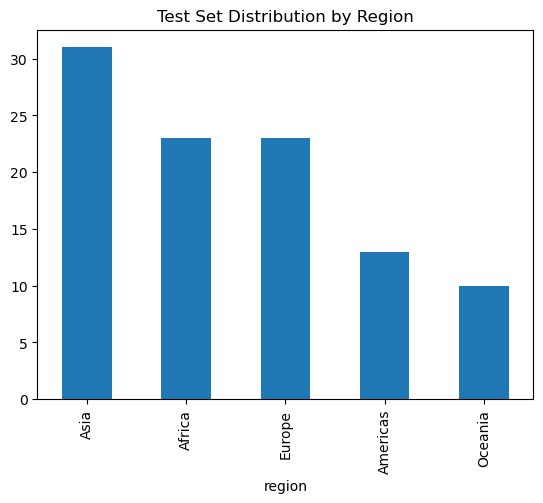

In [6]:
# Step 17: Visualize the distribution in the test set to verify balance
test_region_distribution = test_set['region'].value_counts()
test_region_distribution.plot(kind='bar', title='Test Set Distribution by Region')
plt.show()

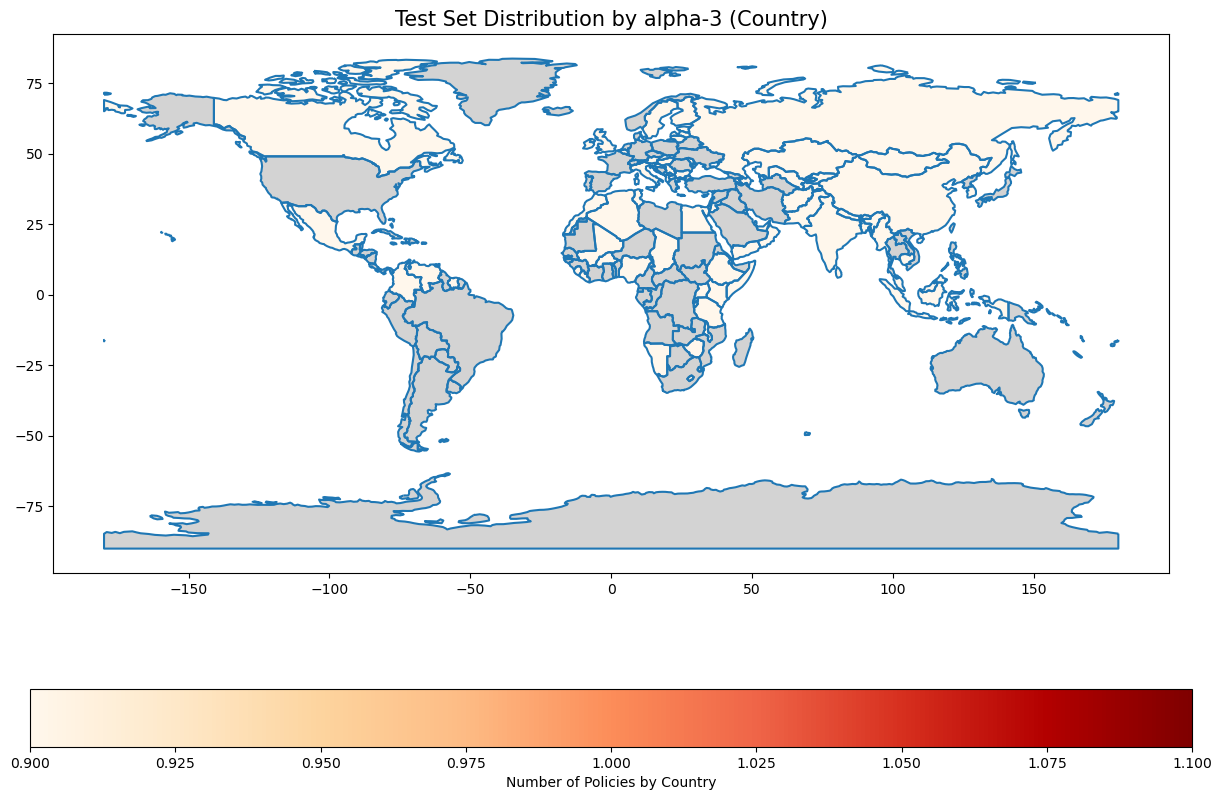

In [7]:
# Get the world map shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a DataFrame from the test set 'alpha-3' distribution
test_alpha_distribution = test_set['alpha-3'].value_counts().reset_index()
test_alpha_distribution.columns = ['alpha-3', 'count']

# Merge the world map with the 'alpha-3' distribution from the test set
# 'iso_a3' column in the world dataset contains ISO 3-letter country codes
world = world.merge(test_alpha_distribution, left_on='iso_a3', right_on='alpha-3', how='left')

# Plot the world map with the distribution data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)  # Plot country boundaries
world.plot(column='count', ax=ax, legend=True, 
           legend_kwds={'label': "Number of Policies by Country", 'orientation': "horizontal"},
           cmap='OrRd', missing_kwds={"color": "lightgrey"})  # Use a color map

# Add title and display the plot
plt.title('Test Set Distribution by alpha-3 (Country)', fontsize=15)
plt.show()

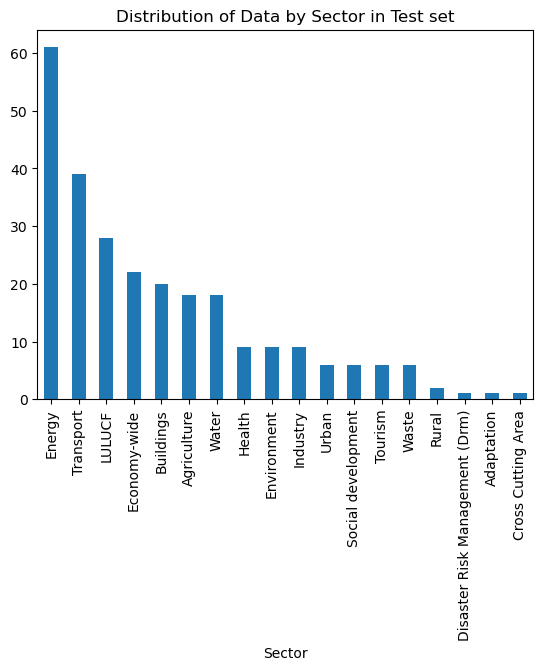

In [8]:
# Visualize the distribution by 'Sector' (handling multiple sectors)
# Split the 'Sector' column by ';' and explode the rows so that each sector is treated separately
test_set_temp = test_set.copy()
test_set_temp['Sector'] = test_set_temp['Sector'].str.split(';')
test_set_temp = test_set_temp.explode('Sector')  # This will create a new row for each sector

# Visualize the distribution of Sectors
test_sector_distribution = test_set_temp['Sector'].value_counts()
test_sector_distribution.plot(kind='bar', title='Distribution of Data by Sector in Test set')
plt.show()

# Save test set

In [17]:
# test_set.to_csv('csv/test.csv', index=False)